# Определение возраста покупателей

Цель проекта состоит в разработке модели компьютерного зрения, способной определять приблизительный возраст человека на фотографии. Эта модель будет интегрирована в систему сетевого супермаркета "Хлеб-Соль" для анализа покупок и предложения товаров, а также для контроля возраста при продаже алкоголя.

*Критерий успешного выполненяи проекта - MAE на тестовой выборке не больше 8*

**Описание данных**

*Признак*

- `file_name` - фотографии людей

*Целевой признак*

- `real_age` - возраст 




**Этапы:**
- Исследовательский анализ данных
- Обучение модели
- Анализ обученной модели
- Вывод

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [3]:
pth1 = 'labels.csv'
pth2 = '/datasets/faces/labels.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('There is no such file')

## Исследовательский анализ данных

**Основная информация выбори**

In [4]:
print(f'Размер выборки: {len(data)}\n')
data.info()

Размер выборки: 7591

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашей выборке отсутсвуют пропущенные значения

In [5]:
fig = px.histogram(data, x='real_age', nbins=30, 
                   title='Распределение возраста в выборке',
                   labels={'real_age': 'Возраст'})
fig.update_traces(marker_color='skyblue', marker_line_color='black',
                  marker_line_width=1)
fig.update_layout(yaxis_title='Кол-во')
fig.show()
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

**Изучим фотографии**

Found 7591 validated image filenames.


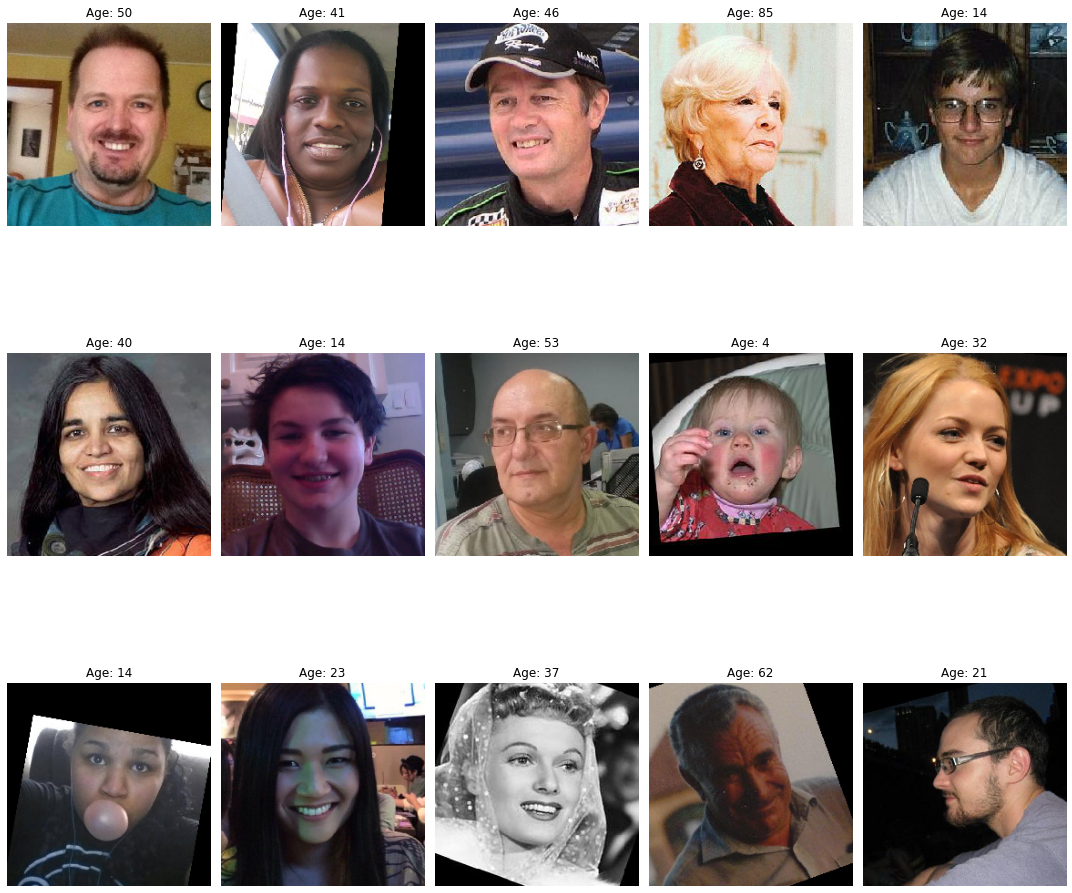

In [6]:
preview_datagen = ImageDataGenerator(rescale=1./255)
preview_gen_flow = preview_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=15,
        class_mode='raw',
        seed=12345) 

images, labels = next(preview_gen_flow)

num_images_to_display = images.shape[0]

num_cols = 5
num_rows = (num_images_to_display + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_images_to_display):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(images[i])
    axes[row, col].set_title("Age: " + str(labels[i]))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

**Вывод:**
- Успешно выполнена загрузка данных, пропуски отсутсвуют.
- В нашей выборке содержится 7591 пример.
- На гистограмме заметна бимодальность распределения.
- Медианный возраст составляет 29 лет, минимальный возраст - 1 год, а максимальный - 100 лет.
- При анализе прикрепленных фотографий можно заметить, что некоторые из них повернуты. Это, вероятно, сделано с целью выравнивания лица. Некоторые изображения содержат артефакты в виде черного и белого фона, оставшихся после поворота и обрезки изображений. Кроме того, в нашем наборе данных присутствуют как цветные, так и черно-белые фотографии.

## Обучение модели

Следующий набор функций использовался для обучения модели глубокого обучения на основе предварительно обученной ResNet50 для решения задачи регрессии.

- load_train() и load_test() загружают и предобрабатывают тренировочные и тестовые данные соответственно.

- create_model() создает модель, добавляя слои ResNet50, GlobalAveragePooling2D и полносвязный слой с активацией ReLU.

- train_model() обучает заданную модель на тренировочных данных, используя тестовые данные для валидации, с учетом заданных параметров обучения.

Этот пайплайн обеспечивает полный процесс обучения модели глубокого обучения для решения задачи регрессии на наборе изображений.

**Код в этом разделе запускается в отдельном GPU-сервисе, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.**

```python
def load_train(path):
    """
    Загружает и подготавливает тренировочные данные для модели обучения.

    Аргументы:
    path (str): Путь к корневой директории, содержащей файл меток и папку с изображениями.

    Возвращает:
    DirectoryIterator: Объект DirectoryIterator, представляющий поток данных изображений и меток для обучения модели.
    """
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 30,
        height_shift_range = 30,
        horizontal_flip = True, 
        rescale=1./255,
        validation_split=.25)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
        """
    Загружает и подготавливает тестовые данные для модели обучения.

    Аргументы:
    path (str): Путь к корневой директории, содержащей файл меток и папку с изображениями.

    Возвращает:
    DirectoryIterator: Объект DirectoryIterator, представляющий поток данных изображений и меток для обучения модели.
    """
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow


def create_model(input_shape):
    """
    Создает модель глубокого обучения на основе предварительно обученной ResNet50 для задачи регрессии.

    Аргументы:
    input_shape (tuple): Форма входных изображений.

    Возвращает:
    keras.models.Sequential: Модель глубокого обучения для задачи регрессии, предварительно обученная на ImageNet.
    """
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(learning_rate = 0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    """
    Обучает заданную модель глубокого обучения на предоставленных данных.

    Аргументы:
    model (keras.models.Sequential): Модель глубокого обучения для обучения.
    train_data (DirectoryIterator): Объект DirectoryIterator с данными для обучения.
    test_data (DirectoryIterator): Объект DirectoryIterator с данными для проверки.
    batch_size (int): Размер пакета данных для обучения. 
    epochs (int): Количество эпох обучения.
    steps_per_epoch (int): Количество шагов (пакетов данных) для одной эпохи обучения.
    validation_steps (int): Количество шагов (пакетов данных) для одной эпохи проверки.
    
    Возвращает:
    keras.models.Sequential: Обученная модель глубокого обучения.
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

```

**Результаты отработки модели**

```

178/178 - 156s - loss: 257.6071 - mean_absolute_error: 11.5950 - val_loss: 1039.9718 - val_mean_absolute_error: 27.5999
Epoch 2/10
178/178 - 112s - loss: 106.8066 - mean_absolute_error: 7.8320 - val_loss: 866.5483 - val_mean_absolute_error: 24.4952
Epoch 3/10
178/178 - 111s - loss: 87.7098 - mean_absolute_error: 7.0892 - val_loss: 291.9703 - val_mean_absolute_error: 12.3670
Epoch 4/10
178/178 - 112s - loss: 76.6215 - mean_absolute_error: 6.6223 - val_loss: 119.0943 - val_mean_absolute_error: 8.2561
Epoch 5/10
178/178 - 109s - loss: 64.8822 - mean_absolute_error: 6.1405 - val_loss: 92.6686 - val_mean_absolute_error: 7.3602
Epoch 6/10
178/178 - 113s - loss: 58.9735 - mean_absolute_error: 5.9013 - val_loss: 76.8664 - val_mean_absolute_error: 6.5987
Epoch 7/10
178/178 - 112s - loss: 51.0420 - mean_absolute_error: 5.5105 - val_loss: 92.4461 - val_mean_absolute_error: 7.5045
Epoch 8/10
178/178 - 107s - loss: 46.3685 - mean_absolute_error: 5.2660 - val_loss: 78.4500 - val_mean_absolute_error: 6.7941
Epoch 9/10
178/178 - 96s - loss: 44.1792 - mean_absolute_error: 5.0743 - val_loss: 88.7031 - val_mean_absolute_error: 7.0958
Epoch 10/10
178/178 - 95s - loss: 39.9954 - mean_absolute_error: 4.8795 - val_loss: 76.2087 - val_mean_absolute_error: 6.3231

60/60 - 10s - loss: 76.2087 - mean_absolute_error: 6.3231
Test MAE: 6.3231

```

## Анализ обученной модели

**Архитектура модели:**

Использовалась архитектура ResNet50, предварительно обученная на наборе данных ImageNet. Модель включает в себя слои ResNet50, GlobalAveragePooling2D и полносвязный слой с активацией ReLU.

**Параметры обучения:**

- Размер пакета данных (batch size): 32
- Оптимизатор: Adam с коэффициентом обучения (learning rate) равным 0.0001
- Функция потерь: Mean Squared Error (MSE)
- Метрики: Mean Absolute Error (MAE)

**Результаты обучения:**

- После 10 эпох обучения на тренировочном наборе данных, функция потерь (loss) составила примерно 39.9954, а средняя абсолютная ошибка (MAE) - около 4.8795.
- На валидационном наборе данных значение функции потерь составило приблизительно 76.2087, а средняя абсолютная ошибка - около 6.3231.
- Исходя из значений функции потерь и метрики MAE, модель показывает хорошую производительность как на тренировочном, так и на валидационном наборе данных.
- Разница между значениями функции потерь на тренировочном и валидационном наборах данных не слишком велика, что указывает на отсутствие переобучения.
- Оценка на тестовом наборе данных показывает, что средняя абсолютная ошибка (MAE) составляет около 6.3231.

## Вывод

Эта модель отлично подходит для персонализации предложений в соответствии с возрастными группами покупателей. Однако, из-за относительно высокой средней абсолютной ошибки (MAE), точность определения возраста может быть недостаточной для контроля добросовестности кассиров при продаже алкоголя. Для улучшения решения можно использовать различные методы, такие как увеличение датасета, использование других предобученных моделей или анализ исходного датасета для улучшения путем модификации существующих данных.
Тем не менее, модель может быть полезной для предварительной оценки возраста с некоторой степенью точности.